## Import and eval functions

In [1]:
%load_ext autoreload
%autoreload 2

import sys, h5py, gc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

REPO_ROOT = "../"
proj = Path(REPO_ROOT).resolve()

# allow: import ADCNN.*
sys.path.insert(0, str(proj))

# allow: import utils.*  (where utils == ADCNN/utils)
sys.path.insert(0, str(proj / "ADCNN"))

import exp_utils.postprocess as postprocess
from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.predict import load_model, predict_tiles_to_full

import ADCNN.evaluation as evaluation
from ADCNN.utils.utils import draw_one_line

test_h5 = "../DATA/test.h5"
test_csv = "../DATA/test.csv"
MODEL_CKPT = "../checkpoints/Best/ckpt_best.pt"
SAVE_PATH = "../checkpoints/Experiments/"

In [2]:
def mark_nn_to_catalog (catalog, predictions, threshold, pixel_gap=10, psf_width=40):
    predictions = predictions >= threshold
    for image_id in catalog["image_id"].unique():
        lab, n = evaluation._label_components_fds(predictions[image_id], pixel_gap=pixel_gap)
        for i, row in catalog[catalog["image_id"]==image_id].iterrows():
            index = np.argwhere((catalog["x"] == row["x"]) & (catalog["y"] == row["y"]) & (catalog["image_id"] == row["image_id"]))[0][0]
            mask = draw_one_line(np.zeros((predictions.shape[1], predictions.shape[2]), dtype=np.uint8), [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=1, line_thickness=int(psf_width/2))
            mask = mask != 0
            intersection = predictions[row["image_id"]] & mask
            lab_ids = np.unique(lab[intersection])
            lab_ids = lab_ids[lab_ids!=0]  # remove background
            lab_removed = np.isin(lab, lab_ids)
            predictions[row["image_id"]][lab_removed] = 0
            if np.any(intersection):
                catalog.at[index, "nn_detected"] = True
            else:
                catalog.at[index, "nn_detected"] = False
    return catalog

def objectwise_confusion (catalog, predictions, threshold, pixel_gap=10, psf_width=40):
    true_positive = 0
    false_negative = 0
    false_positive = 0

    predictions = predictions >= threshold
    for image_id in catalog["image_id"].unique():
        lab, n = evaluation._label_components_fds(predictions[image_id], pixel_gap=pixel_gap)
        predicted_positive = n
        for i, row in catalog[catalog["image_id"]==image_id].iterrows():
            mask = draw_one_line(np.zeros((predictions.shape[1], predictions.shape[2]), dtype=np.uint8), [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=1, line_thickness=int(psf_width/2))
            mask = mask != 0
            intersection = predictions[row["image_id"]] & mask
            lab_ids = np.unique(lab[intersection])
            lab_ids = lab_ids[lab_ids!=0]  # remove background
            lab_removed = np.isin(lab, lab_ids)
            predictions[row["image_id"]][lab_removed] = 0
            if np.any(intersection):
                true_positive += 1
            else:
                false_negative += 1
        false_positive += predicted_positive - true_positive if predicted_positive - true_positive >=0 else 0
    return true_positive, false_positive, false_negative

def evaluate_model_on_catalog (catalog, predictions, ground_truth, threshold):
    catalog = catalog.copy()
    (pix_tp, pix_fp, pix_fn, pix_tn), (_, _, pix_f1, pix_f2) = evaluation.pixelwise_confusion(predictions, ground_truth, thr=threshold)
    obj_tp, obj_fp, obj_fn = objectwise_confusion(catalog, predictions, threshold=threshold, pixel_gap=2, psf_width=40)
    obj_f1 = 2*obj_tp/(2*obj_tp + obj_fp + obj_fn)
    obj_f2 = 5*obj_tp/(5*obj_tp + 4*obj_fn + obj_fp)
    catalog = mark_nn_to_catalog(catalog, predictions, threshold=threshold, pixel_gap=2, psf_width=40)
    results = {
        "pixelwise": {
            "TP": pix_tp,
            "FP": pix_fp,
            "FN": pix_fn,
            "TN": pix_tn,
            "F1": pix_f1,
            "F2": pix_f2
        },
        "objectwise": {
            "TP": obj_tp,
            "FP": obj_fp,
            "FN": obj_fn,
            "TN": -1,
            "F1": obj_f1,
            "F2": obj_f2
        }
    }
    _ = evaluation.plot_detect_hist(catalog, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=" + str(threshold))
    _ = evaluation.plot_detect_hist(catalog, "trail_length", bins=12, title="Detections vs trail length threshold="+ str(threshold))
    _ = evaluation.plot_detect_hist(catalog, "SNR", bins=10, title="Detections vs SNR threshold="+ str(threshold), xlim=[0, 10], density=True)
    print_confusion_matrix(results["pixelwise"], title=f"Pixelwise Confusion Matrix @ thr={threshold}")
    print ()
    print_confusion_matrix(results["objectwise"], title=f"Objectwise Confusion Matrix @ thr={threshold}")

    plt.show()

    return results, catalog

def print_confusion_matrix(cm, title="Confusion Matrix"):
    cm = np.array([[cm["TN"], cm["FP"]], [cm["FN"], cm["TP"]]])
    df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print(title)
    print (f"F1 Score: {cm[1,1]*2/(cm[1,1]*2 + cm[0,1] + cm[1,0]):.4f}, F2 Score: {cm[1,1]*5/(cm[1,1]*5 + cm[0,1] + cm[1,0]*4):.4f}")
    print(df)

In [3]:
ds_te = H5TiledDataset(test_h5,  tile=128, k_sigma=5.0)

test_loader = DataLoader(
    ds_te,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=None,
)

test_catalog = pd.read_csv(test_csv)
with h5py.File(test_h5, "r") as _f:
    gt_test = _f["masks"][:].astype(np.uint8)
print("Test tiles:", len(ds_te))

Test tiles: 51200


## Baseline

In [4]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p_baseline = predict_tiles_to_full(test_h5, test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_baseline.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.1424, F2 Score: 0.1406
                 Predicted Negative  Predicted Positive
Actual Negative           812567654              824952
Actual Positive              866921              140473

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.2397, F2 Score: 0.2021
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 344
Actual Positive                 817                 183


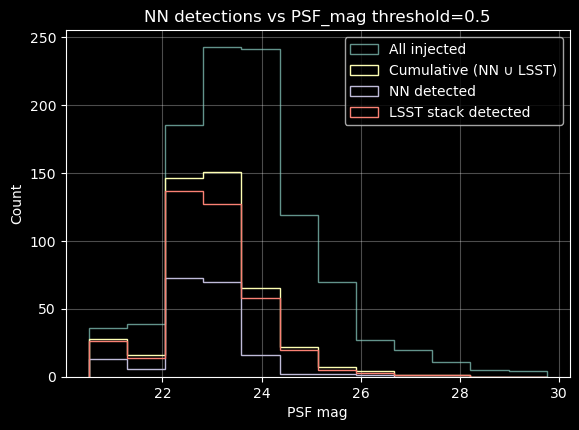

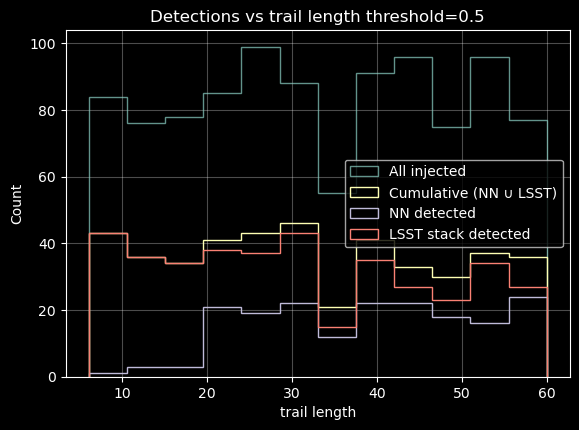

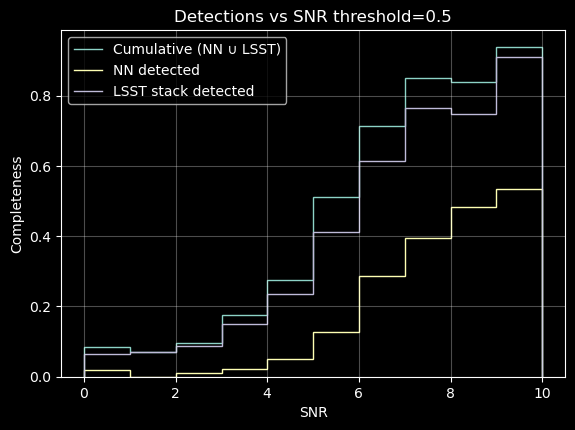

In [5]:
results_baseline, cat_baseline = evaluate_model_on_catalog(test_catalog, p_baseline, gt_test, threshold=0.5)

## Idea 1

Oversampling LSST-missed examples

In [6]:
model_1 = load_model(SAVE_PATH+"Last/idea1.pt")
p_1 = predict_tiles_to_full(test_h5, test_loader, model_1, tile=128)
model_1.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_1.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea1.pt
Predictions shape: (50, 4000, 4072)


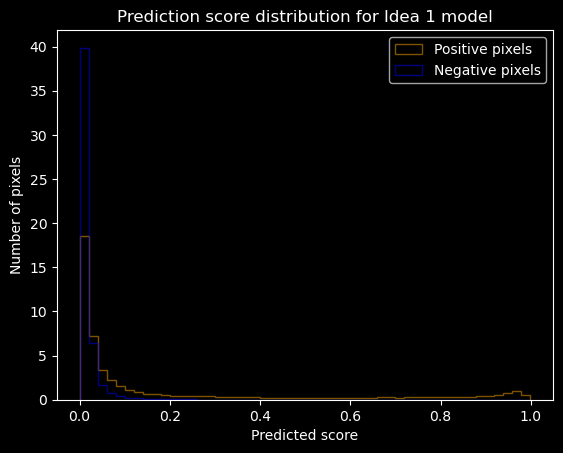

In [7]:
_ = plt.hist(p_1[gt_test>0.5].flatten(), bins=50, alpha=0.5, label="Positive pixels", histtype="step", density=True, color='orange')
_ = plt.hist(p_1[gt_test==0].flatten(), bins=50, alpha=0.5, label="Negative pixels", histtype="step", density=True, color='blue')
_ = plt.xlabel("Predicted score")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
_ = plt.title("Prediction score distribution for Idea 1 model")
plt.show()

Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.1387, F2 Score: 0.1563
                 Predicted Negative  Predicted Positive
Actual Negative           812091654             1300952
Actual Positive              835387              172007

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.2213, F2 Score: 0.2398
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                1042
Actual Positive                 746                 254


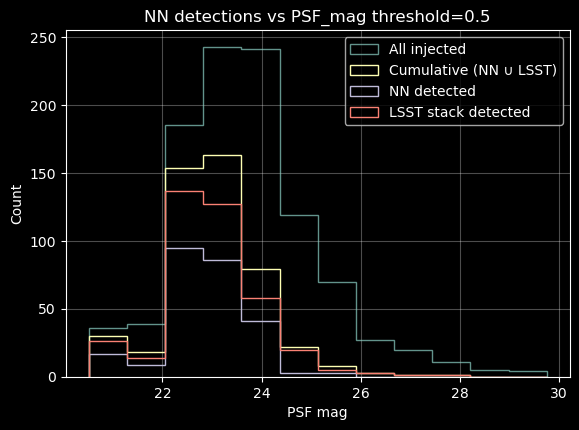

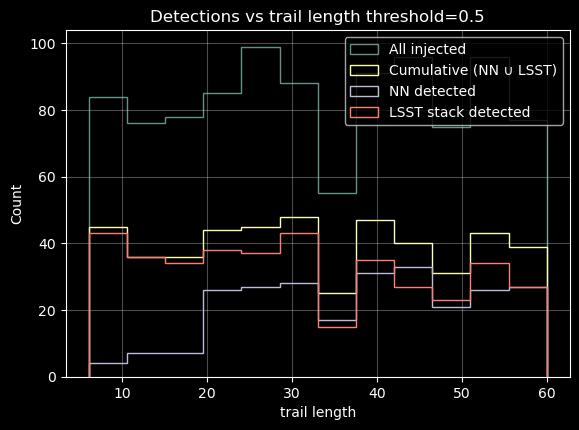

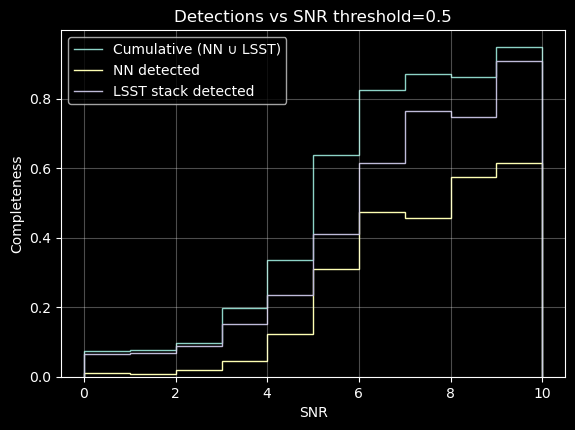

In [8]:
results_1, cat_1 = evaluate_model_on_catalog(test_catalog, p_1, gt_test, threshold=0.5)

## Idea 2

Loss biased toward LSST-missed examples. Weight the loss contribution per sample using lsst_detected: higher weight for LSST-missed, lower for LSST-detected. Optionally apply this weighting only in later epochs.

In [9]:
model_2 = load_model(SAVE_PATH+"Last/idea2.pt")
p_2 = predict_tiles_to_full(test_h5, test_loader, model_2, tile=128)
model_2.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_2.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea2.pt
Predictions shape: (50, 4000, 4072)


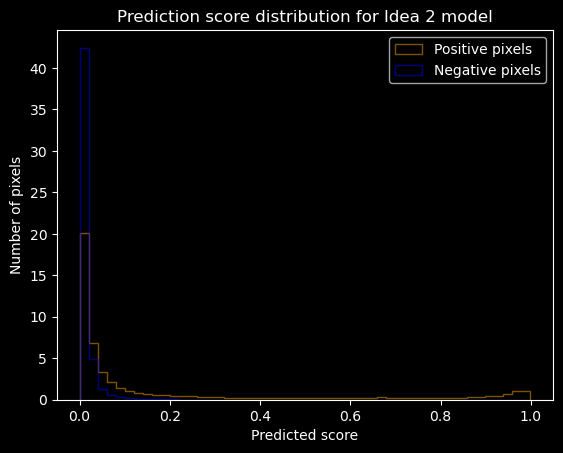

In [10]:
_ = plt.hist(p_2[gt_test>0.5].flatten(), bins=50, alpha=0.5, label="Positive pixels", histtype="step", density=True, color='orange')
_ = plt.hist(p_2[gt_test==0].flatten(), bins=50, alpha=0.5, label="Negative pixels", histtype="step", density=True, color='blue')
_ = plt.xlabel("Predicted score")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
_ = plt.title("Prediction score distribution for Idea 2 model")
plt.show()

Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.1475, F2 Score: 0.1583
                 Predicted Negative  Predicted Positive
Actual Negative           812293370             1099236
Actual Positive              839721              167673

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.2508, F2 Score: 0.2360
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 583
Actual Positive                 773                 227


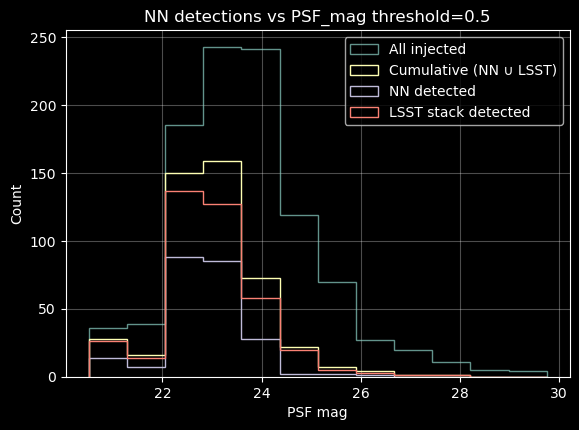

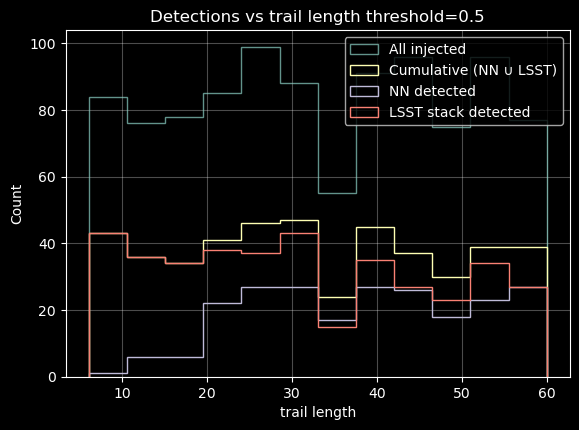

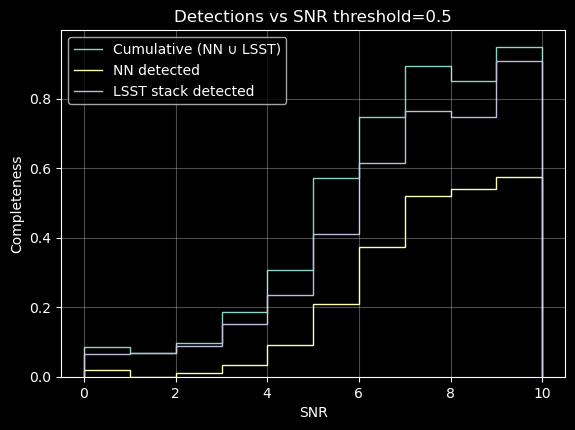

In [11]:
results_2, cat_2 = evaluate_model_on_catalog(test_catalog, p_2, gt_test, threshold=0.5)

## Idea 3

Two-phase loss schedule (BCE → Focal Tversky)

Phase 1: train with BCE (optionally BCE+Dice) for stability.

Phase 2: gradually blend in Focal Tversky: L = (1 - λ) * L_BCE + λ * L_FocalTversky, ramp λ from 0 to 1 over selected epochs. Optionally reduce learning rate at start of Phase 2.

In [12]:
model_3 = load_model(SAVE_PATH+"Last/idea3.pt")
p_3 = predict_tiles_to_full(test_h5, test_loader, model_3, tile=128)
model_3.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_3.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea3.pt
Predictions shape: (50, 4000, 4072)


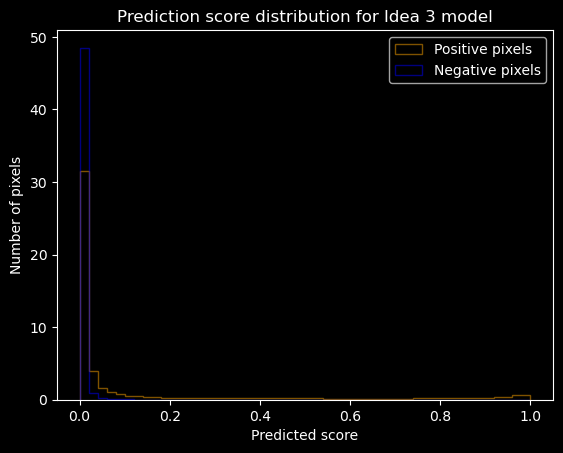

In [13]:
_ = plt.hist(p_3[gt_test>0.5].flatten(), bins=50, alpha=0.5, label="Positive pixels", histtype="step", density=True, color='orange')
_ = plt.hist(p_3[gt_test==0].flatten(), bins=50, alpha=0.5, label="Negative pixels", histtype="step", density=True, color='blue')
_ = plt.xlabel("Predicted score")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
_ = plt.title("Prediction score distribution for Idea 3 model")
plt.show()

Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.1376, F2 Score: 0.1252
                 Predicted Negative  Predicted Positive
Actual Negative           812790703              601903
Actual Positive              888490              118904

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.1838, F2 Score: 0.1932
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 976
Actual Positive                 800                 200


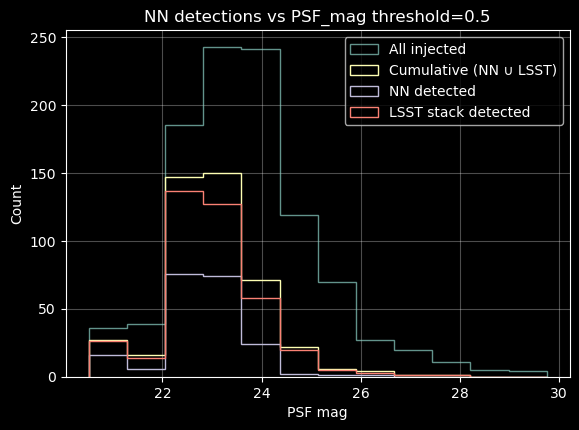

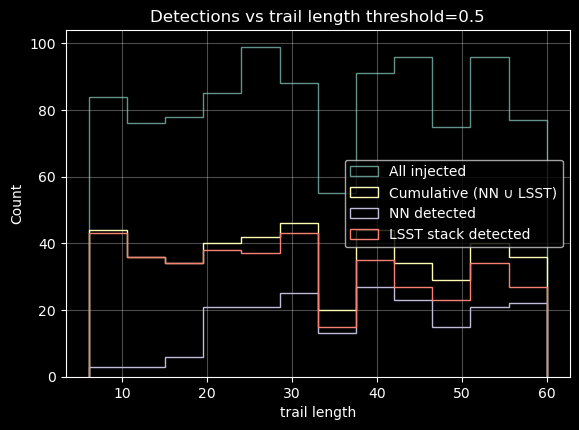

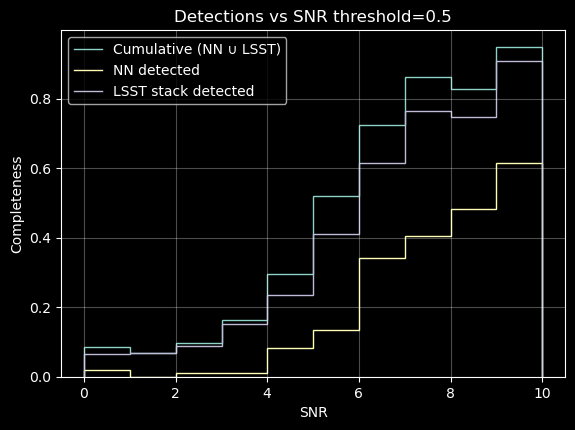

In [14]:
results_3, cat_3 = evaluate_model_on_catalog(test_catalog, p_3, gt_test, threshold=0.5)

## Idea 4

Keep NN output as continuous probability map p(y,x). Use a low pixel threshold t_low only to define connectivity: binary = (p >= t_low). Run connected-component labeling with pixel_gap to obtain candidate regions. For each candidate, compute a score from original probabilities: e.g. max(p) or mean(top-k p). An injected trail is detected if: (a) a candidate overlaps the truth mask, and (b) its score >= score_thr. t_low controls geometry/connectivity, score_thr controls detection confidence.

In [15]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p_baseline = predict_tiles_to_full(test_h5, test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
gc.collect()
torch.cuda.empty_cache()
p_baseline_tt = postprocess.two_threshold_prediction(p_baseline, t_low=0.01)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Processing image 50, component 1834/1834   

Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.0149, F2 Score: 0.0342
                 Predicted Negative  Predicted Positive
Actual Negative           780846370            32546236
Actual Positive              755597              251797

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.3340, F2 Score: 0.2666
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 172
Actual Positive                 765                 235


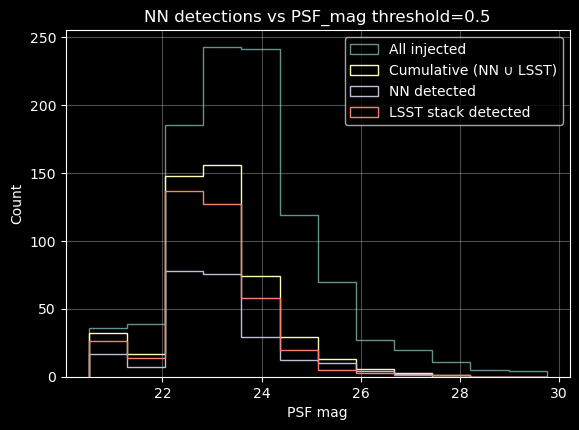

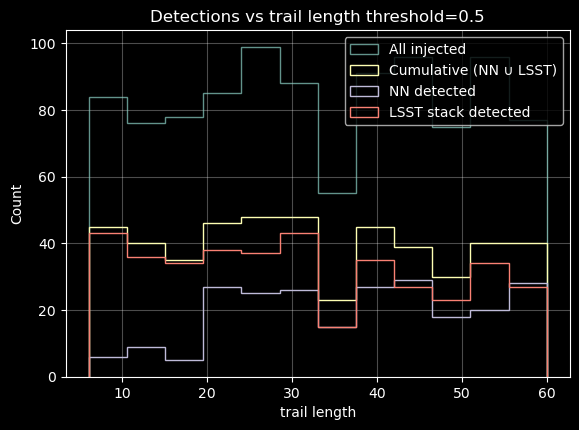

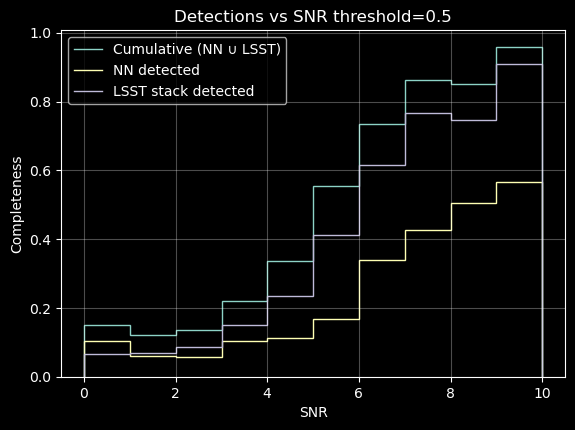

In [16]:
_ = evaluate_model_on_catalog(test_catalog, p_baseline_tt, gt_test, threshold=0.5)

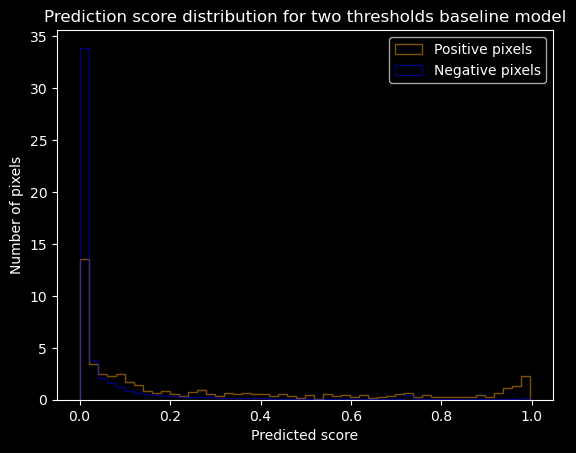

In [17]:
_ = plt.hist(p_baseline_tt[gt_test>0.5].flatten(), bins=50, alpha=0.5, label="Positive pixels", histtype="step", density=True, color='orange')
_ = plt.hist(p_baseline_tt[gt_test==0].flatten(), bins=50, alpha=0.5, label="Negative pixels", histtype="step", density=True, color='blue')
_ = plt.xlabel("Predicted score")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
_ = plt.title("Prediction score distribution for two thresholds baseline model")
plt.show()

## Idea 5

Line coherence bias (loss or auxiliary head)

Encourage elongated, coherent trail-like predictions.

Loss-based option: penalize isolated activations and compact blobs, encourage connectivity and elongation.

In [18]:
model_5 = load_model(SAVE_PATH+"Last/idea5.pt")
p_5 = predict_tiles_to_full(test_h5, test_loader, model_5, tile=128)
model_5.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_5.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea5.pt
Predictions shape: (50, 4000, 4072)


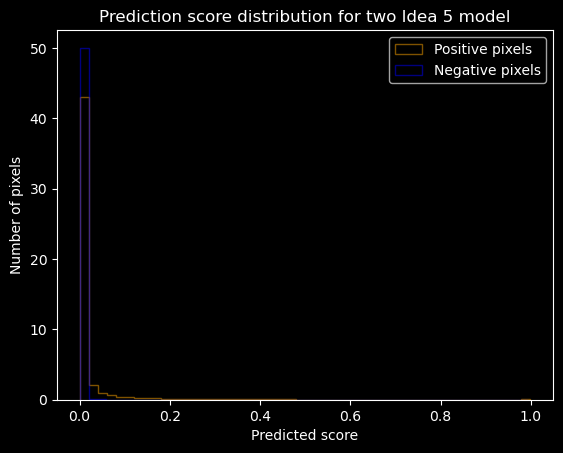

In [19]:
_ = plt.hist(p_5[gt_test>0.5].flatten(), bins=50, alpha=0.5, label="Positive pixels", histtype="step", density=True, color='orange')
_ = plt.hist(p_5[gt_test==0].flatten(), bins=50, alpha=0.5, label="Negative pixels", histtype="step", density=True, color='blue')
_ = plt.xlabel("Predicted score")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
_ = plt.title("Prediction score distribution for two Idea 5 model")
plt.show()

Pixelwise Confusion Matrix @ thr=0.05
F1 Score: 0.0795, F2 Score: 0.0832
                 Predicted Negative  Predicted Positive
Actual Negative           812308673             1083933
Actual Positive              920839               86555

Objectwise Confusion Matrix @ thr=0.05
F1 Score: 0.0640, F2 Score: 0.1033
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                4292
Actual Positive                 825                 175


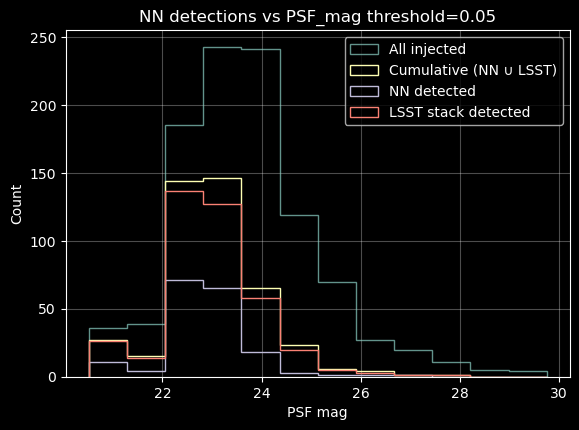

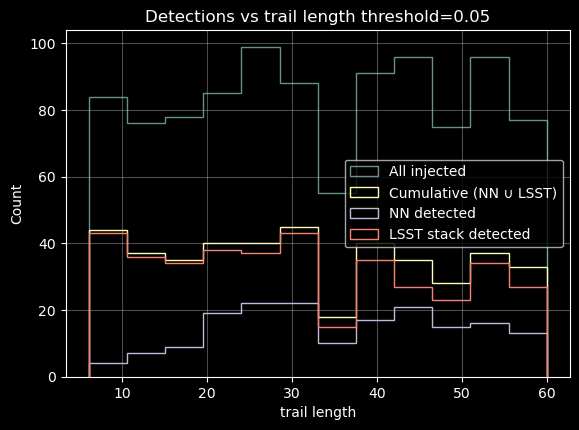

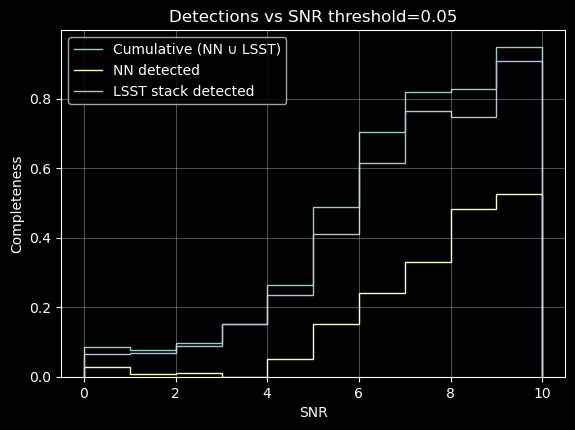

In [20]:
_ = evaluate_model_on_catalog(test_catalog, p_5, gt_test, threshold=0.05)

## Idea 6
Line coherence bias (loss or auxiliary head)

Encourage elongated, coherent trail-like predictions.

Auxiliary-head option: add a head predicting local trail orientation or direction, trained from injection geometry or skeletonized truth masks.

In [21]:
import math
from typing import Dict, Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

def filter_tiles_by_panels(base_ds, panel_ids_set: set[int]) -> np.ndarray:
    out = []
    for ti, (pid, _r, _c) in enumerate(base_ds.indices):
        if int(pid) in panel_ids_set:
            out.append(ti)
    return np.asarray(out, dtype=np.int64)


class TileSubset(Dataset):
    def __init__(self, base, tile_indices: np.ndarray):
        self.base = base
        self.tile_indices = np.asarray(tile_indices, dtype=np.int64)

    def __len__(self) -> int:
        return int(self.tile_indices.size)

    def __getitem__(self, i: int):
        return self.base[int(self.tile_indices[int(i)])]


# -------------------------
# Orientation target builder (from GT mask)
# -------------------------
@torch.no_grad()
def orientation_target_from_mask(
    y: torch.Tensor,
    *,
    blur_ksize: int = 7,
    blur_sigma: float = 1.5,
    dilate: int = 3,
    grad_eps: float = 1e-3,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    y: float tensor [B,1,H,W] in {0,1} (or [B,1,h,w] after resize)
    Returns:
      ori_tgt:  [B,2,H,W] with (cos2, sin2)
      ori_mask: [B,1,H,W] boolean mask where loss is applied
    """
    assert y.ndim == 4 and y.size(1) == 1
    dev = y.device
    yt = y.float()

    # Optional dilation to include nearby pixels around the trail centerline.
    if dilate and dilate > 1:
        k = int(dilate)
        yt_d = F.max_pool2d(yt, kernel_size=k, stride=1, padding=k // 2)
        pos_mask = (yt_d > 0.5)
    else:
        pos_mask = (yt > 0.5)

    # Gaussian blur via separable 1D kernel (cheap, no torchvision dependency).
    if blur_ksize and blur_ksize >= 3:
        k = int(blur_ksize)
        if k % 2 == 0:
            k += 1
        r = k // 2
        xs = torch.arange(-r, r + 1, device=dev, dtype=torch.float32)
        g = torch.exp(-(xs ** 2) / (2.0 * float(blur_sigma) ** 2))
        g = (g / g.sum()).view(1, 1, 1, k)  # horizontal
        yt_blur = F.conv2d(yt, g, padding=(0, r))
        gT = g.transpose(-1, -2)  # vertical
        yt_blur = F.conv2d(yt_blur, gT, padding=(r, 0))
    else:
        yt_blur = yt

    # Sobel filters
    kx = torch.tensor([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]], device=dev, dtype=torch.float32).view(1, 1, 3, 3)
    ky = torch.tensor([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]], device=dev, dtype=torch.float32).view(1, 1, 3, 3)

    gx = F.conv2d(yt_blur, kx, padding=1)
    gy = F.conv2d(yt_blur, ky, padding=1)

    gmag = torch.sqrt(gx * gx + gy * gy)
    # valid where positive and gradient is meaningful
    ori_mask = pos_mask & (gmag > float(grad_eps))

    # Gradient direction is normal to line; tangent is +90deg
    theta = torch.atan2(gy, gx) + (math.pi / 2.0)

    # Use doubled-angle representation to remove 180° ambiguity:
    cos2 = torch.cos(2.0 * theta)
    sin2 = torch.sin(2.0 * theta)
    ori_tgt = torch.cat([cos2, sin2], dim=1)  # [B,2,H,W]
    return ori_tgt, ori_mask.float()


# -------------------------
# Model: UNetResSEASPP + aux orientation head
# (based on your current UNetResSEASPP code)
# -------------------------
class SEBlock(nn.Module):
    def __init__(self, c, r=8):
        super().__init__()
        self.fc1 = nn.Conv2d(c, c // r, 1)
        self.fc2 = nn.Conv2d(c // r, c, 1)

    def forward(self, x):
        s = F.adaptive_avg_pool2d(x, 1)
        s = F.silu(self.fc1(s), inplace=True)
        s = torch.sigmoid(self.fc2(s))
        return x * s


def _norm(c, groups=8):
    g = min(groups, c) if c % groups == 0 else 1
    return nn.GroupNorm(g, c)


class ResBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, act=nn.SiLU, se=True):
        super().__init__()
        p = k // 2
        self.proj = nn.Identity() if c_in == c_out else nn.Conv2d(c_in, c_out, 1)
        self.bn1 = _norm(c_in)
        self.c1 = nn.Conv2d(c_in, c_out, k, padding=p, bias=False)
        self.bn2 = _norm(c_out)
        self.c2 = nn.Conv2d(c_out, c_out, k, padding=p, bias=False)
        self.act = act()
        self.se = SEBlock(c_out) if se else nn.Identity()

    def forward(self, x):
        h = self.act(self.bn1(x))
        h = self.c1(h)
        h = self.act(self.bn2(h))
        h = self.c2(h)
        h = self.se(h)
        return h + self.proj(x)


class Down(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.rb = ResBlock(c_in, c_out)

    def forward(self, x):
        return self.rb(self.pool(x))


class Up(nn.Module):
    def __init__(self, c_in, c_skip, c_out):
        super().__init__()
        self.up = nn.ConvTranspose2d(c_in, c_in, 2, stride=2)
        self.rb1 = ResBlock(c_in + c_skip, c_out)
        self.rb2 = ResBlock(c_out, c_out)

    def forward(self, x, skip):
        x = self.up(x)
        dh = skip.size(-2) - x.size(-2)
        dw = skip.size(-1) - x.size(-1)
        if dh or dw:
            x = F.pad(x, (0, max(0, dw), 0, max(0, dh)))
        x = torch.cat([x, skip], 1)
        x = self.rb1(x)
        x = self.rb2(x)
        return x


class ASPP(nn.Module):
    def __init__(self, c, r=(1, 6, 12, 18)):
        super().__init__()
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(c, c // 4, 3, padding=d, dilation=d, bias=False),
                nn.BatchNorm2d(c // 4),
                nn.SiLU(True),
            )
            for d in r
        ])
        self.project = nn.Conv2d(c, c, 1)

    def forward(self, x):
        return self.project(torch.cat([b(x) for b in self.blocks], 1))


class UNetResSEASPP_AuxOri(nn.Module):
    """
    Returns (seg_logits, ori_pred) where:
      seg_logits: [B,1,H,W]
      ori_pred:   [B,2,H,W] (tanh range)
    """
    def __init__(self, in_ch=1, widths=(32, 64, 128, 256, 512)):
        super().__init__()
        w = widths
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, w[0], 3, padding=1, bias=False),
            nn.BatchNorm2d(w[0]),
            nn.SiLU(True),
            ResBlock(w[0], w[0]),
        )
        self.d1 = Down(w[0], w[1])
        self.d2 = Down(w[1], w[2])
        self.d3 = Down(w[2], w[3])
        self.d4 = Down(w[3], w[4])

        self.aspp = ASPP(w[4])

        self.u1 = Up(w[4], w[3], w[3])
        self.u2 = Up(w[3], w[2], w[2])
        self.u3 = Up(w[2], w[1], w[1])
        self.u4 = Up(w[1], w[0], w[0])

        self.head = nn.Conv2d(w[0], 1, 1)     # segmentation
        self.aux_head = nn.Conv2d(w[0], 2, 1) # orientation (cos2, sin2)

    def forward(self, x):
        s0 = self.stem(x)
        s1 = self.d1(s0)
        s2 = self.d2(s1)
        s3 = self.d3(s2)
        b = self.d4(s3)
        b = self.aspp(b)

        x = self.u1(b, s3)
        x = self.u2(x, s2)
        x = self.u3(x, s1)
        x = self.u4(x, s0)

        seg = self.head(x)
        ori = torch.tanh(self.aux_head(x))
        return seg, ori

class SegOnlyWrapper(nn.Module):
    """Expose only segmentation logits for code paths expecting model(x)->logits Tensor."""
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)
        if isinstance(out, (tuple, list)):
            return out[0]
        return out

def load_model_idea6(ckpt_path):
    ckpt = torch.load(ckpt_path)
    model = UNetResSEASPP_AuxOri(in_ch=1)
    model.load_state_dict(ckpt["state"])
    model.eval()
    print("Loaded model from:", ckpt_path)
    return model

In [22]:
model_6 = load_model_idea6(SAVE_PATH+"Last/idea6.pt")
model_6 = SegOnlyWrapper(model_6)
p_6 = predict_tiles_to_full(test_h5, test_loader, model_6, tile=128)
model_6.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_6.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea6.pt
Predictions shape: (50, 4000, 4072)


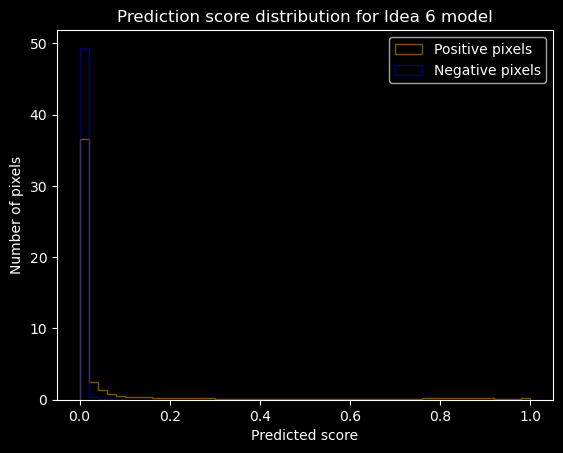

In [23]:
_ = plt.hist(p_6[gt_test>0.5].flatten(), bins=50, alpha=0.5, label="Positive pixels", histtype="step", density=True, color='orange')
_ = plt.hist(p_6[gt_test==0].flatten(), bins=50, alpha=0.5, label="Negative pixels", histtype="step", density=True, color='blue')
_ = plt.xlabel("Predicted score")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
_ = plt.title("Prediction score distribution for Idea 6 model")
plt.show()

Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.1153, F2 Score: 0.0937
                 Predicted Negative  Predicted Positive
Actual Negative           813027272              365334
Actual Positive              923416               83978

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.1960, F2 Score: 0.1596
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 307
Actual Positive                 858                 142


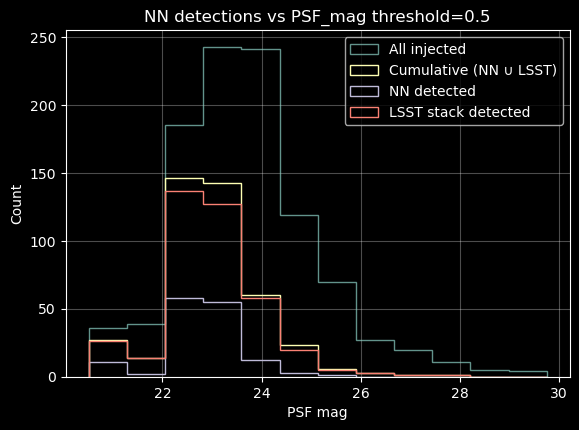

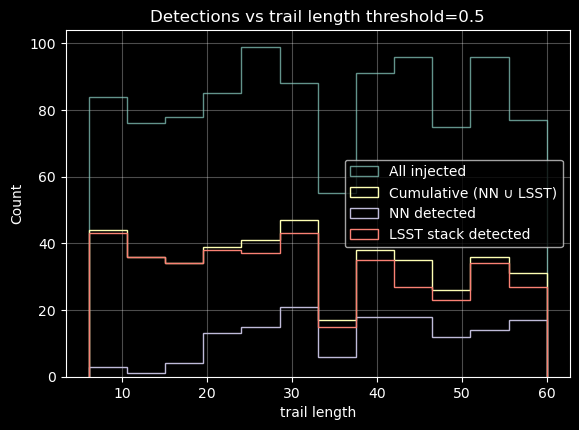

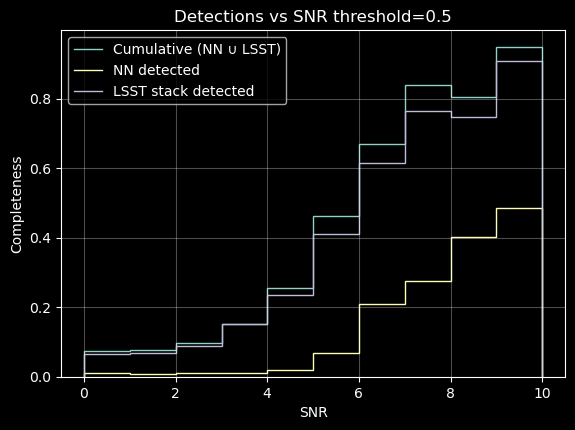

In [24]:
_ = evaluate_model_on_catalog(test_catalog, p_6, gt_test, threshold=0.5)

Processing image 50, component 734/734   Pixelwise Confusion Matrix @ thr=0.1
F1 Score: 0.0243, F2 Score: 0.0540
                 Predicted Negative  Predicted Positive
Actual Negative           790492102            22900504
Actual Positive              713232              294162

Objectwise Confusion Matrix @ thr=0.1
F1 Score: 0.2149, F2 Score: 0.2599
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                1509
Actual Positive                 698                 302


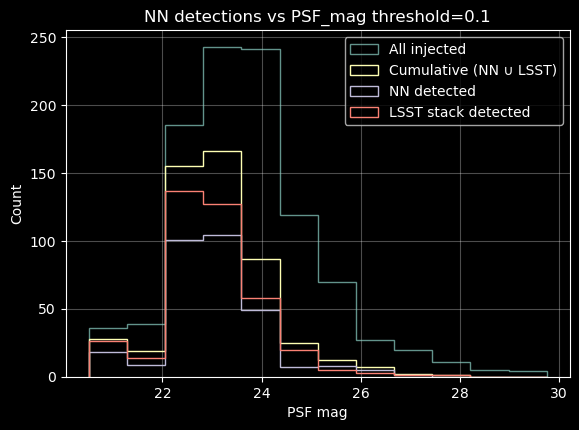

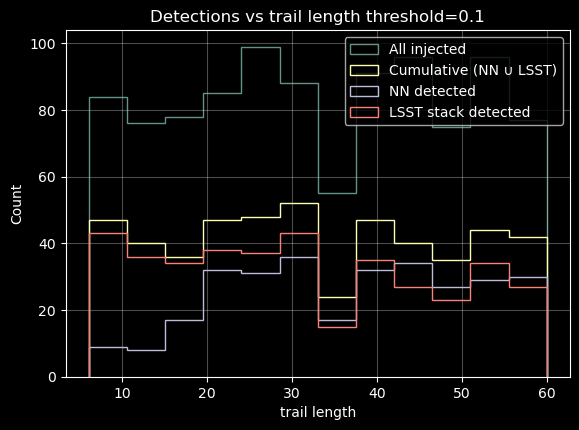

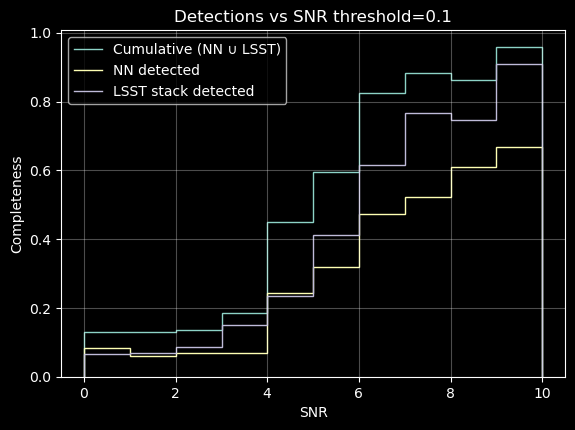

In [25]:
p_6_tt = postprocess.two_threshold_prediction(p_6, t_low=0.025)
_ = evaluate_model_on_catalog(test_catalog, p_6_tt, gt_test, threshold=0.1)